In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import seaborn as sns

from scipy.stats import linregress
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

In [16]:
def create_scatter_hists(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None: 
    # Set the default color cycle
    import pandas as pd
    import seaborn as sns
    import matplotlib as mpl
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    # Create Pandas DataFrame from lists
    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    cmip6 = pd.DataFrame([x6, y6], index=["X", "Y"])
    cmip5 = pd.DataFrame([x5, y5], index=["X", "Y"])
    labels6 = pd.DataFrame([["CMIP6" for i in range(len(x6))]], index=["Ensemble"])
    labels5 = pd.DataFrame([["CMIP5" for i in range(len(x5))]], index=["Ensemble"])
    fbs = cmip6.T.append(cmip5.T, ignore_index=True)
    ens = labels6.T.append(labels5.T, ignore_index=True)
    df = pd.concat([fbs, ens], axis=1)

    # Create JointGrid object using Seaborn containing histogram and scatterplot
    g = sns.JointGrid(data=df, x="X", y="Y", hue="Ensemble")
    g.plot_marginals(sns.kdeplot, fill=True, alpha=.5, legend=False)
    g.plot_joint(sns.scatterplot, s=100, alpha=.5, edgecolor="black", legend=False)

    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))

    # Vertical Lines for Observations 
    if len(vline) >= 1:
        g.ax_joint.vlines(vline[0], ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--", label='Obs', alpha=.75) # ERA5
    if len(vline) >= 2:
        g.ax_joint.vlines(vline[1], ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--",  label='_nolegend_', alpha=.75) # NOAA
    if len(vline) >= 3:
        g.ax_joint.vlines(vline[2], ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--", label='_nolegend_', alpha=.75) # COBE

    # Vertical Lines for Ensemble Means
    g.ax_joint.vlines(np.mean(x5), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[1], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    g.ax_joint.vlines(np.mean(x6), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    
    # Add Letter title
    fig = plt.gcf()
    plt.text(0.05, .9, left_title, fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)
    # Plot Regression Line for Combined Ensemble
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--", label='_nolegend_')
    g.ax_joint.grid()
    plt.text(.15, .75, f'r={r}', fontsize = 12, bbox = dict(edgecolor='white', facecolor = 'white', alpha = 0.5), transform=fig.transFigure, label='_nolegend_')

    # Add Regression Line for CMIP5 and CMIP6
    if len(x5) != 0: 
        slope, intercept, r5, p5, _ = linregress(x5,y5)
        r5, p5 = np.around(r5, 3), np.around(p5, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[1], linestyle="solid")


        slope, intercept, r6, p6, _ = linregress(x6,y6)
        r6, p6 = np.around(r6, 3), np.around(p6, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[0], linestyle="solid")

    # Clean up x and y limits and labels
    g.ax_joint.set_xlim(xmin-borderx, xmax+borderx)
    g.ax_joint.set_ylim(ymin-bordery, ymax+bordery)
    g.ax_joint.set_xlabel(xlabel)
    g.ax_joint.set_ylabel(ylabel)
    # plt.grid()
    plt.legend(labels=[f"CMIP5 r={r5}", f"CMIP6 r={r6}", "Obs"], bbox_to_anchor=(1,0), loc="lower right",  bbox_transform=fig.transFigure)

In [3]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)
    
swcf_cmip6, sst_ept_cmip6 = get_shared_models(xr.open_dataarray("data/piControl/swcf_east_sa_cmip6.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc"))
swcf_cmip5, sst_ept_cmip5 = get_shared_models(xr.open_dataarray("data/piControl/swcf_east_sa_cmip5.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc"))

/tmp/ipykernel_179614/3049744438.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fbs = cmip6.T.append(cmip5.T, ignore_index=True)
/tmp/ipykernel_179614/3049744438.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ens = labels6.T.append(labels5.T, ignore_index=True)


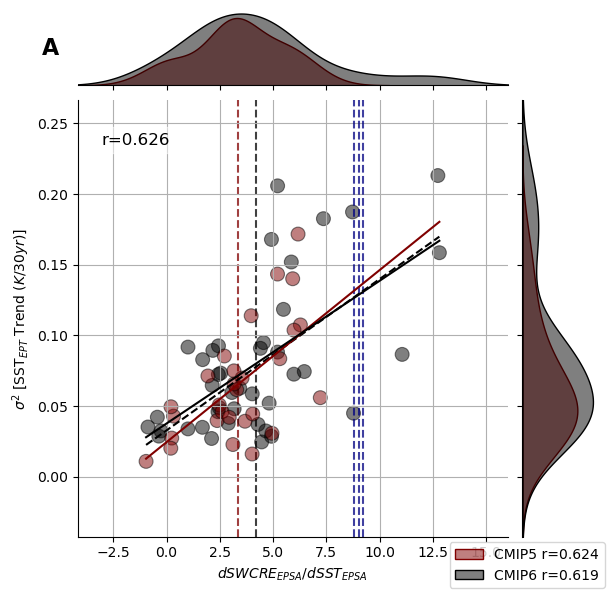

In [18]:
create_scatter_hists(swcf_cmip6.values, sst_ept_cmip6.var("time").values, swcf_cmip5.values, sst_ept_cmip5.var("time").values, vline=[9.033, 8.813, 9.20], left_title="A", xlabel=r"$dSWCRE_{EPSA}/dSST_{EPSA}$", ylabel=r"$\sigma^2$ [SST$_{EPT}$ Trend ($K/30yr$)]")

In [5]:
import scipy.stats as stats
import random

mean = 0
threshold = np.mean([-.228, -.22])  # Replace t with your desired threshold
# threshold = np.mean([-.35, -.38])  # Replace t with your desired threshold
obs_swcf = [9.033, 8.813, 9.20]
# obs_swcf = [10.5, 11.0]
sample_size = 40

swcf = xr.concat([swcf_cmip6, swcf_cmip5], dim="model")
sst_ept = xr.concat([sst_ept_cmip6, sst_ept_cmip5], dim="model")


# Bootstrap
niters = 2000
p_obs, p_model, p_diff = [], [], []
for iter in range(niters): 
    all_numbers = list(range(0, len(swcf.model.values)))
    # Shuffle the list to achieve randomness
    random.shuffle(all_numbers)
    # Select the first n elements from the shuffled list
    random_models = all_numbers[:sample_size]
    swcf_sub = swcf.isel(model=random_models)
    sst_ept_sub = sst_ept.isel(model=random_models)
    reg = linregress(swcf_sub.values, sst_ept_sub.std("time").values)
    # print(reg)
    # print(sst_ept_sub.var("time").values)
    # import pdb; pdb.set_trace() 
    estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
    obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)
    # print(obs_normal_dist.cdf(threshold))
    p_obs.append(obs_normal_dist.cdf(threshold))
    
    multimodel_mean_variance = sst_ept_sub.std("time").mean("model")
    # print(estimated_obs_variance, multimodel_mean_variance)
    # Create a normal distribution with the specified mean and variance
    model_normal_dist = stats.norm(loc=mean, scale=multimodel_mean_variance)
    # print(model_normal_dist.cdf(threshold))
    p_model.append(model_normal_dist.cdf(threshold))

    p_diff.append(obs_normal_dist.cdf(threshold) - model_normal_dist.cdf(threshold))

p_obs = np.array(p_obs)*100
p_model = np.array(p_model)*100
p_diff = np.array(p_diff)*100

In [6]:
x = np.linspace(-1., 1., 100)
reg = linregress(swcf.values, sst_ept.std("time").values)
estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)

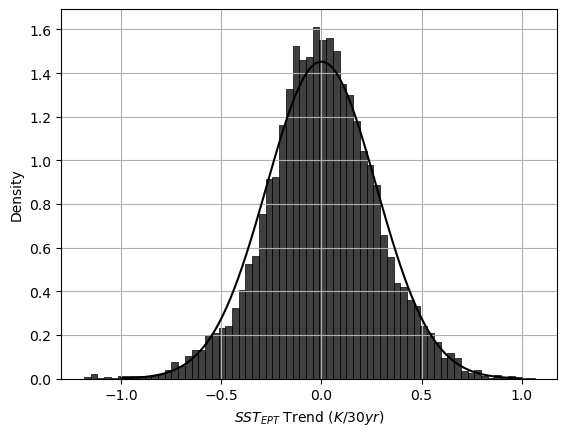

In [7]:
raw_normal_dist = stats.norm(loc=mean, scale=np.std(sst_ept.values.flatten()))
sns.histplot(sst_ept.values.flatten(), stat="density")
plt.plot(x, raw_normal_dist.pdf(x), label="obs")
plt.xlabel(r"$SST_{EPT}$ Trend ($K/30yr$)")
plt.grid()

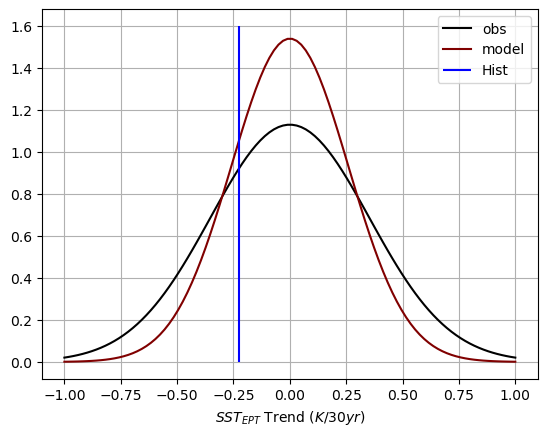

In [8]:
x = np.linspace(-1., 1., 100)
reg = linregress(swcf.values, sst_ept.std("time").values)
estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)
model_normal_dist = stats.norm(loc=mean, scale=sst_ept.std("time").mean("model"))

plt.plot(x, obs_normal_dist.pdf(x), label="obs")
plt.plot(x, model_normal_dist.pdf(x), label="model")
plt.vlines([threshold], ymin=0, ymax=1.6, color="blue", label="Hist")  # Replace t with your desired threshold
plt.xlabel(r"$SST_{EPT}$ Trend ($K/30yr$)")
plt.legend()
plt.grid()
# sns.histplot()
# sns.histplot(p_model)

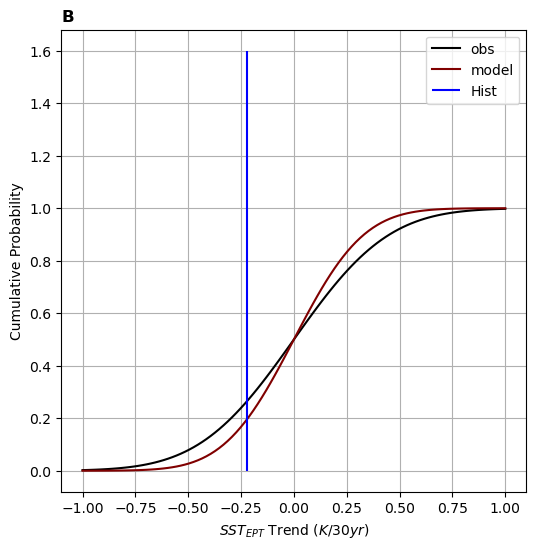

In [22]:
plt.plot(x, obs_normal_dist.cdf(x), label="obs")
plt.plot(x, model_normal_dist.cdf(x), label="model")
plt.vlines([threshold], ymin=0, ymax=1.6, color="blue", label="Hist")  # Replace t with your desired threshold
plt.legend()
plt.xlabel(r"$SST_{EPT}$ Trend ($K/30yr$)")
plt.ylabel(r"Cumulative Probability")
plt.title("B", fontweight="bold", loc="left")
fig = plt.gcf()
fig.set_size_inches(6, 6)

plt.grid()

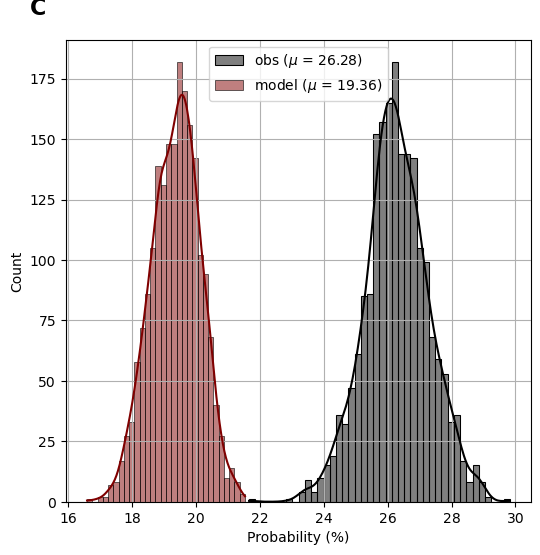

In [27]:

obs_mu = np.around(np.nanmean(p_obs), 2)
model_mu = np.around(np.nanmean(p_model), 2)
diff_mu = np.around(np.nanmean(p_diff), 2)
sns.histplot(p_obs, label=f"obs ($\mu$ = {obs_mu})", kde=True) #stat='density')
sns.histplot(p_model, label=f"model ($\mu$ = {model_mu})", kde=True) #, stat='density')
plt.legend()
plt.grid()
plt.xlabel("Probability (%)")
# plt.title("C", fontweight="bold", loc="left")
plt.text(0.05, .9, "C", fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)
fig = plt.gcf()
fig.set_size_inches(6, 6)

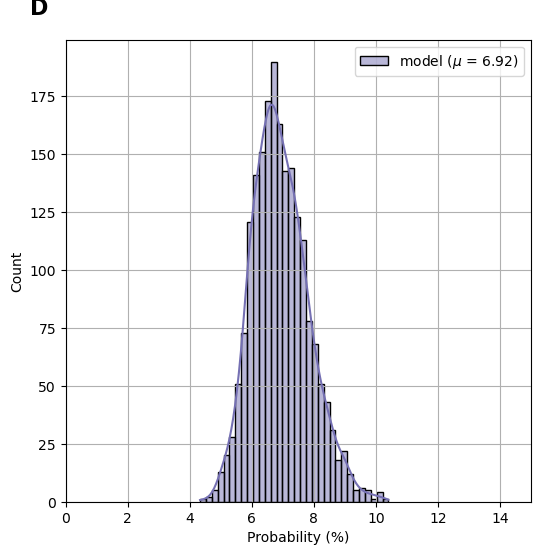

In [42]:
sns.histplot(p_diff, label=f"model ($\mu$ = {diff_mu})", kde=True, color='#7570b3')
plt.xlim(0, 15)
plt.legend()
plt.grid()
plt.xlabel("Probability (%)")
# plt.title("D", fontweight="bold", loc="left", fontsize=16)
plt.text(0.05, .90, "D", fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)
fig = plt.gcf()
fig.set_size_inches(6, 6)
